# Analysis of combinatorial coding of identity (Fig 7) - Leave-one-out validation of classifier

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [8]:
# Gene expression
df_all = pd.read_csv("../data/df_GH146_Fig2.csv.gz", header=0, index_col=0)

# Cluster labels
df_labels_all = pd.read_csv("../data/labels_HDBSCAN.csv", sep="\t", header=0, index_col=0)

In [9]:
# Load names of TFs and CSM genes
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

def write_list(X, outfile):
    with open(outfile, 'w') as out:
        for x in X:
            out.write(str(x) + "\n")

CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")
genes_genome_noTFs_noCSMs = list(set(list(df_all.index)) - set(TFs) - set(CSMs))

In [10]:
# Discretize expression levels
bins = [0, 3, 18]
labels = ["Off", "On"]
df_discrete_all = pd.cut(df_all.values.flatten(), bins=bins, labels=labels, include_lowest=True)
df_discrete_all = pd.DataFrame(np.array(df_discrete_all).reshape(df_all.shape))
df_discrete_all.columns = df_all.columns
df_discrete_all["symbol"] = df_all.index
df_discrete_all.set_index("symbol", inplace=True)

# Here we have an example of running leave-one-out cross-validation for one cell. The rest of the cells are implemented in a separate script for deployment on a cluster.

# Train classifier: identify gene set with maximum mutual information with cluster identity

In [11]:
# Define functions for information theory analysis

# Compute mutual information between each gene and cluster assignment
from sklearn.metrics import mutual_info_score
def calc_mutual_information(df_discrete, labels):
    mutual_informations = []
    for symbol, row in df_discrete.iterrows():
        mi = mutual_info_score(row, labels) / np.log(2) # calculate mutual information, convert from nats to bits
        mutual_informations.append(mi)
    df_result = pd.DataFrame()
    df_result["symbol"] = df_discrete.index
    df_result.set_index("symbol", inplace=True)
    df_result["mutual_information"] = mutual_informations
    df_result.sort_values("mutual_information", inplace=True, ascending=False)
    return df_result

# Calculate mean expression of each gene within each cluster
def calc_summary_by_label(df, labels, summary_func=np.mean):
    df_temp = copy.deepcopy(df.T)
    df_temp["label"] = labels
    df_summary_by_label = df_temp.groupby("label").aggregate(summary_func).T
    del df_temp
    return df_summary_by_label

# Calculate total information of a gene set
def calc_cumulative_information_of_set(df_discrete, genes, df_labels):
    """ Calculates total information of gene set """
    # Entropy of class without knowledge of genes
    H_naive = scipy.stats.entropy(df_labels["label"].value_counts(normalize=True), base=2)
    # Get discretized gene expression matrix with only selected genes
    df_temp = df_discrete.loc[genes].T

    H = 0
    # Find unique combinations of expression levels
    for _, row in df_temp.drop_duplicates().iterrows():
        cell_names = df_temp.index[np.all(df_temp == row, axis=1)] # Get cell names having this unique combination of expression levels
        labels_cond = df_labels.loc[cell_names]["label"] # Get class labels of cells
        # Calculate entropy of classification (conditional on expression levels)
        H_cond = scipy.stats.entropy(labels_cond.value_counts(normalize=True), base=2)
        weight = len(cell_names) / df_temp.shape[0] # Weight by fraction of cells in this set
        H += H_cond*weight

    I = H_naive - H
    return I

# Calculate total information for each gene set defined by iteratively adding a single gene
# starting from the beginning of the list genes
def calc_cumulative_informations(df_discrete, genes, df_labels, N=5):
    """ Calculates total information of gene sets starting from top of df """
    cis = []
    for i in range(0,N):
        my_ci = calc_cumulative_information_of_set(df_discrete, genes[:i+1], df_labels)
        cis.append(my_ci)
    cis = np.array(cis)
    df_result = pd.DataFrame()
    df_result["symbol"] = genes
    df_result.set_index("symbol", inplace=True)
    df_result["cumulative_mutual_information"] = ""
    df_result["cumulative_mutual_information"] = np.nan
    df_result["cumulative_mutual_information"].loc[genes[:N]] = cis
    return df_result

# Define function to pick non-redundant genes

def find_nonredundant_gene_set(df_discrete, genes,
                               df_labels,
                               df_info,
                               H_naive,
                               N_constrain=20,
                               cumulative_information_cutoff=0.99,
                               verbose=False):
        
    cis = []
    nonredundant_genes = []
    current_ci = 0
    current_relative_ci = 0.0
    
    # Rank genes by mutual information
    remaining_genes = list(df_info.loc[genes]["mutual_information"].sort_values(ascending=False).head(n=N_constrain).index)
    
    i = 0
    
    while True:
        
        i +=1
        
        # Calculate information gain for each gene
        df_info_gains = pd.DataFrame(index=list(remaining_genes))
        my_info_gains = []
        
        for gene in remaining_genes:
            my_genes = nonredundant_genes + [gene]
            my_ci = calc_cumulative_information_of_set(df_discrete, my_genes, df_labels)
            my_info_gain = my_ci - current_ci
            my_info_gains.append(my_info_gain)
        
        df_info_gains["info_gain"] = my_info_gains
        
        # Sort genes by information gain
        df_info_gains.sort_values("info_gain", ascending=False, inplace=True)
        
        # Take best gene
        hit = df_info_gains["info_gain"].index[0]
        
        nonredundant_genes.append(hit)
        remaining_genes.remove(hit)
        current_ci = current_ci + df_info_gains.iloc[0]["info_gain"]
        current_relative_ci = current_ci / H_naive
        
        if verbose:
            print hit
            print current_relative_ci
            print
        
        if len(remaining_genes) == 0 or current_relative_ci > cumulative_information_cutoff:
            return nonredundant_genes
        
def head_threshold(df, threshold, field="relative_cumulative_information"):
    L = max(np.where(df[field] <= threshold)[0])+2
    print L
    return df.iloc[:L]

In [12]:
# Remove one cell from data to form training set
name_test_index = 0
name_test = df_discrete_all.columns[name_test_index]
df_discrete = df_discrete_all.drop(name_test, axis=1)
df = df_all.drop(name_test, axis=1)
df_labels = df_labels_all.drop(name_test, axis=0)

In [13]:
### Train classifier

# Compute mutual information between each gene and cluster assignment
df_info = calc_mutual_information(df_discrete, df_labels["label"])

# Calculate median expression of each gene within each cluster
df_expr_labels = calc_summary_by_label(df, df_labels["label"], summary_func=np.median)

# Calculate relative cumulative information
# Entropy of classification without gene expression data
H_naive = scipy.stats.entropy(df_labels["label"].value_counts(normalize=True), base=2)
print "Total entropy of classification", H_naive, "bits"

Total entropy of classification 4.51210955302 bits


In [14]:
# Find non-redundant gene set
genes_nonredundant = find_nonredundant_gene_set(df_discrete, df_info.head(n=30).index,
                                                df_labels, df_info, H_naive,
                                                N_constrain=30,
                                                cumulative_information_cutoff=0.99,
                                                verbose=False)
print genes_nonredundant

['kn', 'CG17278', 'C15', 'otp', 'dati', 'twz', 'pdm3', 'br', 'unpg', 'caup', 'DIP-eta', 'CG11317', 'CG31814', 'fru', 'CG2082']


In [15]:
# Calculate relative cumulative information with increasingly large codes

df_info_nonredundant = df_info.copy()

# Calculate cumulative information for top N genes
cumulative_informations = calc_cumulative_informations(df_discrete, genes_nonredundant,
                                                       df_labels, N=len(genes_nonredundant))
df_info_nonredundant["cumulative_information"] = cumulative_informations["cumulative_mutual_information"]

# Calculate information relative to total entropy
relative_cumulative_informations = df_info_nonredundant["cumulative_information"] / H_naive
df_info_nonredundant["relative_cumulative_information"] = relative_cumulative_informations

df_info_nonredundant.sort_values("relative_cumulative_information", inplace=True)

In [16]:
# Prune to minimal code (having > 0.95 cumulative information)
genes_nonredundant_minimal = list(head_threshold(df_info_nonredundant, 0.95).index)

11


# Classify test set

In [17]:
# Get test cell's profile
state_to_label = {"On": 1, "Off": 0}
profile_test = df_discrete_all[name_test].loc[genes_nonredundant_minimal] # get expression profile of test cell
profile_test = [state_to_label[x] for x in profile_test] # convert to integer coding

# Find binary expression profile of each cluster
df_discrete_labels = df_expr_labels.loc[genes_nonredundant_minimal] > 3
df_discrete_labels = df_discrete_labels.drop(-1, axis=1)

# Compare test cell's profile to each cluster
Z = df_discrete_labels == profile_test # comparison
scores = np.sum(Z, axis=0) # calculate scores (hamming distance)
max_score = max(scores) # find maximum score among scores
classifications = list(np.where(scores == max_score)[0]) # get classification of test set

# Get true label of test cell
true_label = df_labels_all.loc[name_test]["label"]

# Compare classification result with true label
if len(classifications) == 1:
    # only one classification output with top score
    success = float(classifications[0] == true_label)
elif len(classifications) > 1:
    # multiple classification outputs tied for top score
    if true_label in classifications:
        # assume random choice between tied classes
        success = 1/float(len(classifications))
    else:
        success = 0.
elif len(classifications) == 0:
    success = 0.

In [18]:
# Report results
print name_test
print str(H_naive)
print ",".join(genes_nonredundant_minimal)
print success

N357Barcode_719-507
4.51210955302
kn,CG17278,C15,otp,dati,twz,pdm3,br,unpg,caup,DIP-eta
1.0


# Plot results

In [28]:
# Build confusion matrix

num_labels = df_labels["label"].value_counts().shape[0] - 1

confusion = pd.DataFrame(0, index=np.arange(num_labels), columns=np.arange(num_labels)) # initialize counts to zero
accuracies = [] # keep track of accuracies

for i in range(0, 902):
    infile = "LeaveOneOutValidation/validate_GH146_CombinatorialCode.out." + str(i) + ".csv"
    with open(infile) as f:

        name = f.readline().rstrip()
        label_true = int(df_labels_all.loc[name])
        if label_true == -1: continue
        
        f.readline()
        f.readline()
        f.readline()
        predictions = map(int, f.readline().rstrip().split(","))
        weight = 1/float(len(predictions))
        
        accuracy = float(f.readline().rstrip())
        accuracies.append(accuracy)
        
        # tally up number of predictions for each true/predicted combination
        for prediction in predictions:
            confusion.loc[label_true, prediction] += weight

In [29]:
# normalize confusion matrix
# divide by total number of cases with True label
# thus, diagonal represents the fraction of cases with the given True label that are classified correctly
confusion_normed = confusion.div(confusion.sum(axis=1), axis=0) # fraction of cases that are classified as combination

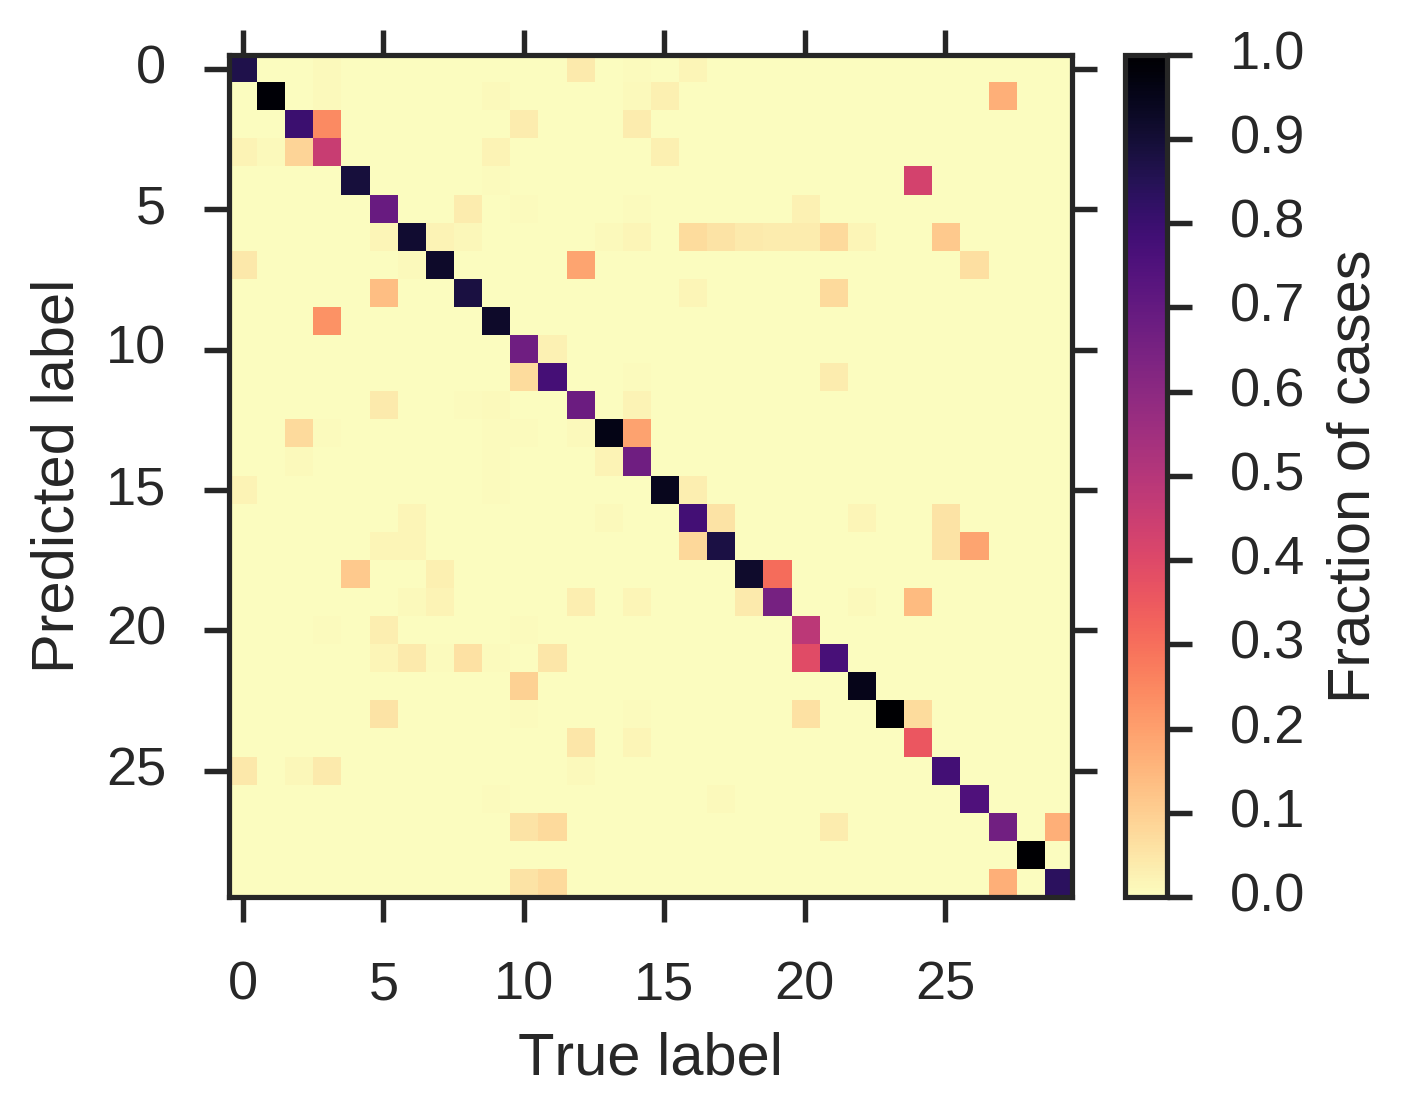

In [30]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 1, figsize=(5,4))
im = ax.imshow(confusion_normed.T, cmap='magma_r', interpolation='nearest')
fig.colorbar(im, label="Fraction of cases")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")
plt.tight_layout()

In [31]:
print "Fraction of cases that are correctly classified"
print sum(np.diag(confusion)) / sum(confusion.sum())
print
print "Mean accuracy is the same thing"
print np.mean(accuracies)

Fraction of cases that are correctly classified
0.815243445693

Mean accuracy is the same thing
0.815243445693
